In [1]:
%run stdPackages.ipynb

# A Basic Model of the Electricity System with Hourly Variation

We consider a ```mBasicInt```-like model that can be represented by the optimization problem:

$$\begin{align}
    \max W &= \sum_h\left(\sum_c u_c\cdot D_{h,c}-\sum_i c_i \cdot E_{h,i}\right)-\sum_i \text{FOM}_i\cdot q_i \tag{1a} \\
    \sum_c D_{h,c} &= \sum_i E_{h,i} \tag{1b} \\
    c_i &= c_i^{oth}+\sum_j\mu_j^i\cdot p_j^f + p_{CO2} \cdot \nu_i \tag{1c} \\
    \nu_i &= \sum_j\mu_j^i\phi_j \tag{1d} \\
    D_{h,c} &\in[0, L_{h,c}], \qquad L_{h,c} \equiv L_c \cdot \upsilon_{h,c} \tag{1e} \\ 
    E_{h,i} &\in[0, q_{h,i}], \qquad q_{h,i} \equiv q_i\cdot \gamma_{h,i} \tag {1f}
\end{align}$$


Here:
* $u_c$ is the marginal willingness to pay for electricity for consumer $c$ (*the model only includes one consumer though*).
* $D_{h,c}$ is the consumption of electricity in hour $h$ by consumer $c$.
* $c_i$ is the marginal cost of generation for plant $i$. 
* $E_{h,i}$ is the MWh of electricity generation in hour $h$ for plant $i$.
* $\text{FOM}_i$ is the fixed cost of plant $i$. This is measured as 1000 €/MW generating capacity (i.e. 1000 € per $q_i$)
* $q_i$ is the installed generating capacity of plant $i$.
* $\mu_j^i$ is the input-share of energy carrier $j$ for generator $i$ (i.e. MWh input of fuel $j$ per MWh output from generator $i$).
* $p_j^f$ is the price of carrier $j$ measured in €/MWh.
* $p_{CO2}$ is a tax on CO2 emissions (€/ton CO2).
* $\nu_i$ is the emission intensity of generator $i$ (i.e. ton of CO2 per MWh of output generated by plant $i$).
* $\phi_j$ is the emission intensity of energy carrier $j$.
* $L_c$ is the yearly maximum load in MWh,
* $L_{h,c}$ is the maximum load/demand consumer $c$ has in hour $h$, with $\upsilon_{h,c}\in[0,1]$ reflecting variation in demand.
* $q_{h,i}$ is the hourly generating capacity of plant $i$, with $\gamma_{h,i}\in[0,1]$ reflecting variation in natural conditions e.g. wind speed.

The file *PS4.xlsx* includes some simulated hourly variation data that we will use throughout. Table 1 translates the names used in the data to the symbols in the model. The data uses 12 representative days - one for each month of the year - to represent the yearly variation in an electricity system. Thus, the data includes 24$\cdot$12 $=$ 288 hours in total. Tables 1-2 translates the names used in the data to the symbols used in the model above:

| **Table 1: Symbols Dictionary** | |
| --- | --- |
| *Name in excel data* | *Model Symbol* |
| FuelMix | $\mu_j^i$ |
| EmissionIntensity | $\phi_j$ |
|FuelPrice | $p_j^f$ |
| EmissionTax | $p_{CO2}$ |
| Load | $L_c$ |
| LoadVariation | $\upsilon_{h,c}$ |
| MWP | $u_c$ |
| GeneratingCapacity | $q_i$ |
| CapVariation | $\gamma_{h,i}$ |
| OtherMC | $c_i^{oth}$ |
| FOM | $\text{FOM}_i$ |

| **Table 2: Index Dictionary** | |
| --- | --- |
| *Name in excel data* | *Model Index* |
| BFt | $j$ |
| id | $i$ |
| h | $h$ |
| c | $c$ |

*The following uses the package ```pyDbs``` to load and arrange the data in a simple key,value like database. It has a few methods that reads in symbols from excel and add them as pandas series with the appropriate pandas indices. This is what we use here to read in the data:*

In [2]:
db = pyDbs.read.dbFromWB(os.path.join(d['data'], 'PS4.xlsx'),
                        {'variables': ['Fundamentals','Load','Generator'],
                         'variable2D': ['FuelMix', 'HourlyVariation'],
                         'maps': ['GeneratorCategories']})
pyDbs.readSets(db) # this method adds indices from the declared symbols to the database.

*Note: In the data, the hourly variation in generating capacity is defined over an index ```hvt``` which is simply short for "hourly variation types". As you can see in the data, "standard" with a constant hourly productivity $\gamma_{h,i} = 1$ or the type "Wind". The mapping ```id2hvt``` shows what category the three plants are in this model; only plant 'C' is a "wind" type.*

## Q1. Writing a Model Class

Consider the optimization model in equations (1). In this exercise, we will build an energy system model to solve this based on the ```lpModels``` framework. You should write this custom model class in the file ```pyfiles/E4.py```. This file already includes some base functions that you should apply throughout.

*This snippet loads the classes/methods that you've defined in ```pyfiles/E4.py:```*

In [3]:
os.chdir(d['curr'])
from pyfiles.S4 import * # this imports everything from the file

### **Q1.1. Test and explain base functions in the class**

*The ```customModel``` class in ```E4.py``` already contains a number of methods. Now, initialize an instance of the class with the database ```db``` from above and use the method ```mc``` from the ```E4.py``` file to compute the marginal costs of the different plants; add this to the database.*

*Test and briefly explain the following:*
1. *What does it mean that ```h``` and ```h_constr``` are aliased?*
2. *What does ```hourlyGeneratingCapacity``` return?*
2. *What does ```hourlyCapFactors``` return?*
2. *What does ```hourlyLoad_c``` return?*

**Solution:**

In [4]:
m = customModel(db) # initialize
m.db['mc'] = mc(db) # add marginal costs to the database (1c)

1. ```h``` and ```h_constr``` are aliased means that ```h_constr``` is basically a copy of the index $h$.

In [5]:
pd.DataFrame({'h': m.db['h'], 'h_constr': m.db['h_constr']})

,h,h_constr
0,"(1, 1)","(1, 1)"
1,"(1, 2)","(1, 2)"
2,"(1, 3)","(1, 3)"
3,"(1, 4)","(1, 4)"
4,"(1, 5)","(1, 5)"
...,...,...
283,"(12, 20)","(12, 20)"
284,"(12, 21)","(12, 21)"
285,"(12, 22)","(12, 22)"
286,"(12, 23)","(12, 23)"


2. ```hourlyGeneratingCapacity``` returns $q_{i,h}$:

In [6]:
m.hourlyGeneratingCapacity

id  h       
A   (1, 1)             60
    (1, 2)             60
    (1, 3)             60
    (1, 4)             60
    (1, 5)             60
                  ...    
C   (12, 20)    52.567244
    (12, 21)    52.587454
    (12, 22)    53.024454
    (12, 23)     53.57843
    (12, 24)    53.934745
Length: 864, dtype: object

3. ```hourlyCapFactors``` returns $\gamma_{h,i}$:

In [7]:
m.hourlyCapFactors

h        id
(1, 1)   A            1
         B            1
(1, 10)  A            1
         B            1
(1, 11)  A            1
                 ...   
(9, 5)   C     0.030942
(9, 6)   C     0.022674
(9, 7)   C     0.019218
(9, 8)   C      0.70672
(9, 9)   C     0.010767
Length: 864, dtype: object

4. ```hourlyLoad_c``` returns $L_{c, h}$:

In [8]:
m.hourlyLoad_c

c           h       
Consumer 1  (1, 1)       80.368826
            (1, 2)       77.316503
            (1, 3)       75.689608
            (1, 4)       74.997063
            (1, 5)       75.078476
                           ...    
            (12, 20)     133.27888
            (12, 21)    125.158381
            (12, 22)      96.91692
            (12, 23)     90.479093
            (12, 24)     84.081333
Length: 288, dtype: object

### **Q1.2. The ```globalDomains``` property**

The property ```globalDomains``` helps to keep track of what symbols (e.g. $E$ and $D$) are defined over what sets; it is a dictionary where the key = the name of the symbol and the value =  the ```pd.Index``` that the symbol is defined over. In the ```mBasic``` model that we saw in problem set 3, for instance, the ```globalDomains``` property looked like this:

```python
    @property
    def globalDomains(self):
        return {'Generation': self.db['id'],
                'Demand': self.db['c']}
```


In the model in equations (1), the model ultimately consists of two variables ($E_{i,h}$ and $D_{c,h}$) and one variational constraint (the equilibrium one in 1b). The global domains method is defined as 

```python 
	@property
	def globalDomains(self):
		return {'Generation': pd.MultiIndex.from_product([self.db['h'], self.db['id']]),
				'HourlyDemand': pd.MultiIndex.from_product([self.db['c'], self.db['h']]),
				'equilibrium': self.db['h_constr']}
```

*Test and explain each line briefly*

**Solution:**

The variable $E_{h,i}$ is called 'Generation' in the model. This symbol is defined over all combinations of $h$ and $i$:

In [9]:
m.globalDomains['Generation']

MultiIndex([(  '(1, 1)', 'A'),
            (  '(1, 1)', 'B'),
            (  '(1, 1)', 'C'),
            (  '(1, 2)', 'A'),
            (  '(1, 2)', 'B'),
            (  '(1, 2)', 'C'),
            (  '(1, 3)', 'A'),
            (  '(1, 3)', 'B'),
            (  '(1, 3)', 'C'),
            (  '(1, 4)', 'A'),
            ...
            ('(12, 21)', 'C'),
            ('(12, 22)', 'A'),
            ('(12, 22)', 'B'),
            ('(12, 22)', 'C'),
            ('(12, 23)', 'A'),
            ('(12, 23)', 'B'),
            ('(12, 23)', 'C'),
            ('(12, 24)', 'A'),
            ('(12, 24)', 'B'),
            ('(12, 24)', 'C')],
           names=['h', 'id'], length=864)

Similar for $D_{c,h}$ and 'HourlyDemand':

In [10]:
m.globalDomains['HourlyDemand']

MultiIndex([('Consumer 1',   '(1, 1)'),
            ('Consumer 1',   '(1, 2)'),
            ('Consumer 1',   '(1, 3)'),
            ('Consumer 1',   '(1, 4)'),
            ('Consumer 1',   '(1, 5)'),
            ('Consumer 1',   '(1, 6)'),
            ('Consumer 1',   '(1, 7)'),
            ('Consumer 1',   '(1, 8)'),
            ('Consumer 1',   '(1, 9)'),
            ('Consumer 1',  '(1, 10)'),
            ...
            ('Consumer 1', '(12, 15)'),
            ('Consumer 1', '(12, 16)'),
            ('Consumer 1', '(12, 17)'),
            ('Consumer 1', '(12, 18)'),
            ('Consumer 1', '(12, 19)'),
            ('Consumer 1', '(12, 20)'),
            ('Consumer 1', '(12, 21)'),
            ('Consumer 1', '(12, 22)'),
            ('Consumer 1', '(12, 23)'),
            ('Consumer 1', '(12, 24)')],
           names=['c', 'h'], length=288)

The equilibrium constraint 'equilibrium' has to hold for all hours in the model. To signal that the index is a different one than the one $E_{h,i}$ and $D_{c,h}$ are defined over, we add that this symbol 'equilibrium' is defined over the *aliased* index ```h_constr```:

In [11]:
m.globalDomains['equilibrium'] # note the name of the index is 'h_constr' instead of 'h'

Index(['(1, 1)', '(1, 2)', '(1, 3)', '(1, 4)', '(1, 5)', '(1, 6)', '(1, 7)',
       '(1, 8)', '(1, 9)', '(1, 10)',
       ...
       '(12, 15)', '(12, 16)', '(12, 17)', '(12, 18)', '(12, 19)', '(12, 20)',
       '(12, 21)', '(12, 22)', '(12, 23)', '(12, 24)'],
      dtype='object', name='h_constr', length=288)

### **Q1.3. Add domain constraints/bounds to the model**

In the ```customModel``` class, we have already added a method that defines the ```c```-vector of the linear programming (LP) problem (cf. ```lpCompiler_PartI.ipynb``` in the documentation folder). Specifically, we have:

```python
    @property
	def c(self):
		return [{'varName': 'Generation', 'value': adjMultiIndex.bc(self.db['mc'], self.db['h'])},
				{'varName': 'HourlyDemand', 'value': -adjMultiIndex.bc(self.db['MWP'], self.globalDomains['HourlyDemand'])}]
```

For the symbol 'Generation', for instance, this specifies that the ```c```-vector in the LP problem should consist of the marginal costs repeated for all hours:

In [12]:
m.c[0]['value']

id  h       
A   (1, 1)      23.407048
    (1, 2)      23.407048
    (1, 3)      23.407048
    (1, 4)      23.407048
    (1, 5)      23.407048
                  ...    
C   (12, 20)          5.0
    (12, 21)          5.0
    (12, 22)          5.0
    (12, 23)          5.0
    (12, 24)          5.0
Length: 864, dtype: object

For the symbol 'HourlyDemand', this repeats the marginal willingness to pay to all hours:

In [13]:
m.c[1]['value']

c           h      
Consumer 1  (1, 1)     -100
            (1, 10)    -100
            (1, 11)    -100
            (1, 12)    -100
            (1, 13)    -100
                       ... 
            (9, 5)     -100
            (9, 6)     -100
            (9, 7)     -100
            (9, 8)     -100
            (9, 9)     -100
Length: 288, dtype: object

*Use this syntax to define the upper bound vector ```u``` of the problem, by writing the missing lines for the property ```self.u```.*

**Solution:**

The two symbols 'Generation' and 'HourlyDemand' have upper bounds $q_{h,i}$ and $L_{c,h}$. Remember from **Q1.1** that we can get these by calling ```self.hourlyGeneratingCapacity``` and ```self.hourlyLoad_c```. Thus, we can write:

```python
	@property
	def u(self):
		return [{'varName': 'Generation', 'value': self.hourlyGeneratingCapacity},
				{'varName': 'HourlyDemand', 'value': self.hourlyLoad_c}]
```

### **Q1.4. Explain the rest of the model specification**

Recall from ```lpCompiler_PartI.ipynb``` from the documentation that the classes we build here can help us fill in some default values. For instance:
* If no value of ```c``` is provided for generator $i$ in hour $h$ - the model fills in a zero here.
* If no value of ```l``` is provided, it uses a zero as well.
* If no value of ```u``` is provided, it uses a ```np.inf``` (no bound).

Similarly, if we have not provided information on parts of the other components (the vectors ```b_eq, b_ub``` or the matrices ```A_eq, A_ub```), the compiler fills in zeros here as well.


*Using what you have read in the documentation, make sure that you understand how this small snippet defines the entire model in equations (1).*

```python
@property
	def c(self):
		return [{'varName': 'Generation', 'value': adjMultiIndex.bc(self.db['mc'], self.db['h'])},
				{'varName': 'HourlyDemand', 'value': -adjMultiIndex.bc(self.db['MWP'], self.globalDomains['HourlyDemand'])}]
	@property
	def u(self):
		return [{'varName': 'Generation', 'value': self.hourlyGeneratingCapacity},
				{'varName': 'HourlyDemand', 'value': self.hourlyLoad_c}]
	@property
	def b_eq(self):
		return [{'constrName': 'equilibrium'}]
	@property
	def A_eq(self):
		return [{'constrName': 'equilibrium', 'varName': 'Generation', 'value': appIndexWithCopySeries(pd.Series(1, index = self.globalDomains['Generation']), 'h','h_constr')},
				{'constrName': 'equilibrium', 'varName': 'HourlyDemand', 'value': appIndexWithCopySeries(pd.Series(-1, index = self.globalDomains['HourlyDemand']), 'h','h_constr')}]
```

**Solution:**

* The ```c``` and ```u``` vectors are covered. 
* The lower bounds ```l``` in this model are all zeros (eqs. 1e-1f); as this is used per default, we do not need to specify any of this.
* Similarly, there are no inequality constraints in the model, so we can ignore these.
* The equilibrium constraint does not include any constants, i.e. it should be written as:
$$\begin{align}
    \sum_i E_{h,i} - \sum_c L_{c,h} = 0, \qquad \forall h.
\end{align}$$
    As the model uses zeros in the vector ```b_eq``` as a default, we do not need to provide any ```value``` in the specification here.
* The explanation for the ```A_eq``` matrix is provided in more detail in the documentation.

## Q2. Solution and experiments in ```customModel```

### **Q2.1. Draw and explain the *load duration curve* and *residual demand curve***

**Solution:**

The load duration curve:

In [14]:
LDC = m.hourlyLoad.sort_values(ascending=False) # sum load over consumers 'c' and sort values in descending order.
LDC.index = [i/len(LDC) for i in range(1, len(LDC)+1)] # Set the index to the share of the year that has passed at hour 'h'

Residual demand curve is the demand after *intermittent* generation (this is only plant 'C' in our case):

In [15]:
RDC = m.hourlyLoad-m.hourlyGeneratingCapacity.xs('C', level = 'id') # demand after hourly capacity from plant 'C' (wind type)
RDC = RDC.sort_values(ascending = False)
RDC.index = [i/len(RDC) for i in range(1, len(RDC)+1)]

Plot them:

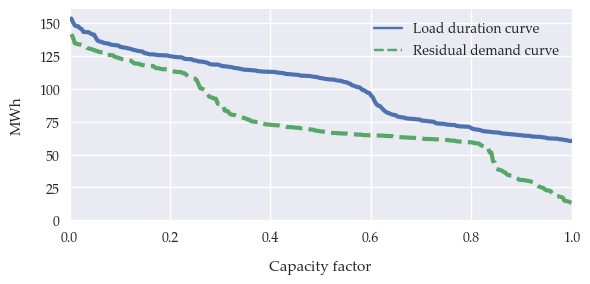

In [16]:
fig, ax = plt.subplots(1,1,figsize = (6,3));
seaborn.lineplot(data = pd.DataFrame({'Load duration curve': LDC, 'Residual demand curve': RDC}),
                 ax = ax, linewidth = 3);
ax.set_ylabel('MWh', labelpad=10);
ax.set_ylim([0, 160]);
ax.set_xlim([0,1]);
ax.set_xlabel('Capacity factor', labelpad =10);
fig.tight_layout();
fig.savefig(os.path.join(d['figs'], "S4_Q21.pdf"),edgecolor='k') # save as pdf

### **Q2.2. Solve and comment on profitability of plants**

*Solve the model and:*
1. *Plot sorted hourly prices.*
2. *Plot capacity factors for each generator.*
3. *The model solution automatically reports shadow values on constraints and variables using the syntax ```λ_x``` for a symbol ```x```. Explain how the following formula gets you the 'marginal economic value' of a generator (as defined in the main lecture note in eq. 16):*
```python
def marginalEconomicValue(model):
	return - pyDbs.pdSum(model.db['λ_Generation'].xs('u',level='_type') * model.hourlyCapFactors, 'h').add( 1000 * model.db['FOM'], fill_value = 0)
``` 
4. *Based on the first three, comment on the profitability of each of the three generators.*

*Hints:*
* *We solve the model simply using the ```m()``` syntax.*
* *Shadow values are reported with syntax ```λ_x```, with an added index level called ```_type```. This indicates whether the shadow variable is the value of an equilibrium constraint (```eq```), an upper bound (```u```) or similar.*

**Solution:**

In [17]:
m() # solve

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


1. Sorted hourly prices

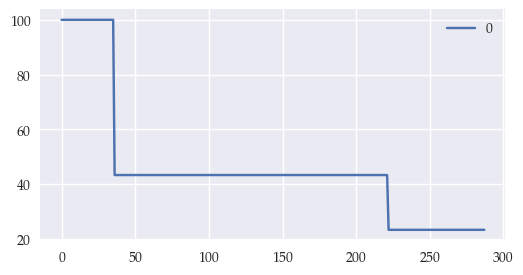

In [18]:
prices = m.db['λ_equilibrium'].droplevel('_type').rename_axis('h') # hourly prices
prices.sort_values(ascending=False).reset_index().plot(figsize=(6,3)); # plot sorted hours

2. Capacity factors

Capacity factor is the sum of 'Generation' divided by the maximum capacity:

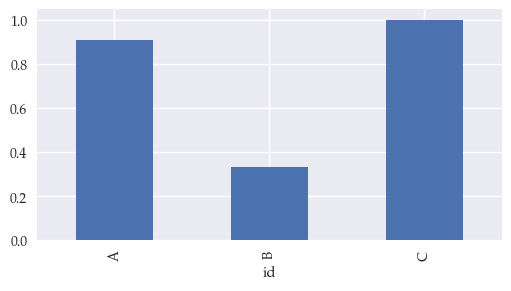

In [19]:
capacityFactor = ( pyDbs.pdSum(m.db['Generation'], 'h')/
                  pdNonZero(pyDbs.pdSum(m.hourlyGeneratingCapacity, 'h')) ).dropna()
capacityFactor.plot.bar(figsize = (6,3));

3. Marginal economic value:

* First, we note that we get the shadow variable $\overline{\theta}_{h,i}^E$ by calling ```db['λ_Generation'].xs('u',level='_type')``` (the 'u' ```_type``` indicates upper bound). 
* We multiply ```FOM``` by 1000, as it measures fixed costs in 1000 € (all other variables are measured simply in €).
* We take the negative value because the LP model always *minimizes* an objective function; note in equations (1) that we *maximize* a welfare function. We are actually telling the model to minimize $-W$. Thus, if the marginal economic value is positive, it means that $-W$ becomes *more* negative.

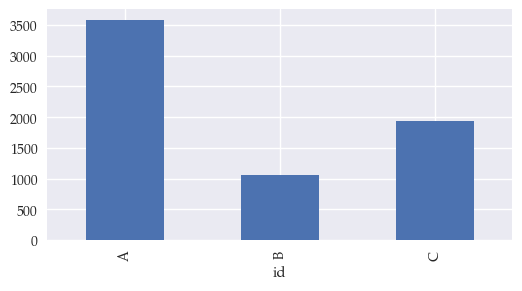

In [20]:
def marginalEconomicValue(model):
	return - pyDbs.pdSum(model.db['λ_Generation'].xs('u',level='_type') * model.hourlyCapFactors, 'h').add( 1000 * model.db['FOM'], fill_value = 0)
mev = marginalEconomicValue(m)
mev.plot.bar(figsize=(6,3));

4. Profitability:

* The wind turbine - plant $C$ - has the lowest marginal costs and is thus active throughout the year (capacity factor of $1$). 
* However, the generator with the highest marginal economic value is plant $A$. This is the case *even though* it has higher marginal costs *and* higher FOM.
* The reason is that plant $A$ produces more power when the hourly prices are much higher. Thus, the economic value that it generates is much higher. This is what we refer to as the *revenue* channel or conversely the *balancing problem* for the intermittent wind turbine.

### **Q2.3. Compute the correlation coefficient between the hourly variation in demand $L_{c,h}$ and the wind turbines productivity $\gamma_{h,i}$. How do you think your answer to  Q2.2. would change if the correlation was negative?**

**Solution:**

The correlation is roughly $0.2$:

In [21]:
corr = pd.concat([m.hourlyCapFactors.xs('C',level='id'), m.hourlyLoad], axis =1).astype(float).corr()
corr

,0,1
0,1.000000,0.202831
1,0.202831,1.000000


*Ceteris paribus*, we would expect the marginal economic value of the wind turbine to be much lower if the correlation was negative instead.

### **Q2.4. Include simple Ramp-Up-Constraints (RUR) in the model**

Assume that dispatchable plants (generators $A,B$) cannot simply increase its production from 0 to 100\% from hour to hour. Specifically, assume that:

$$\begin{align}
    E_{i,h}-E_{i,h-1} \leq \text{RUR}_i\cdot q_i, \qquad \forall i, h \tag{2}
\end{align}
$$

where $\text{RUR}_i\in[0,1]$ is a ramp-up rate. For the wind turbine ($C$), we assume that $\text{RUR}_i$ = 1, indicating that there are no ramp-up constraints here. 


*Incorporate the ramp-up constraint in the optimization problem. Derive the new first order conditions for $E_{i,h}$ and interpret briefly.*

*Hint: For the interpretation part, it might help to think of a scenario where - without the ramp-up constraints - a generator is not used in hour $h$, but very much needed in hour $h+1$.*

**Solution:**

With the ramp-up constraint included, the Lagrangian can be written as:

$$\begin{align}
        \mathcal{L} &= W+\sum_h\left(\Lambda_h+\Theta_h^D+\sum_i\Theta_{i,h}^E+\sum_{i,h}\Lambda_{i,h}^{RUR}\right) \\
        \Lambda_h &\equiv \lambda_h\left(\sum_i E_{i,h} - D_h\right) \notag \\ 
        \Theta_h^D &\equiv \underline{\theta}_h^DD_h+\overline{\theta}_h^D\left(L_h-D_h\right) \notag\\
        \Theta_{i,h}^E &\equiv \underline{\theta}_{i,h}^EE_{i,h} + \overline{\theta}_{i,h}^E\left(q_{i,h}-E_{i,h}\right) \notag \\ 
        \Lambda_{i,h}^{RUR}&\equiv \lambda_{i,h}^{RUR}\left(\text{RUR}_i\cdot q_i-\left[E_{i,h}-E_{i,h-1}\right]\right). \notag
\end{align}$$

Here, all $\lambda$, $\underline{\theta}$, and $\overline{\theta}$. symbols are shadow variables on the relevant constraints and $W$ is the objective function from earlier. The first order condition with respect to $E_{i,h}$ is now given by:
\begin{align}
    \dfrac{\partial \mathcal{L}}{\partial E_{i,h}} = -c_i+\lambda_h+\underline{\theta}_{i,h}^E-\overline{\theta}_{i,h}^E-\lambda_{i,h}^{RUR}+\lambda_{i,h+1}^{RUR} = 0.
\end{align}
Without the RUR constraint, the shadow variables $\lambda^{RUR}$ drops out. To provide some intuition consider the following technical argument:

* Assume that  -- without the RUR constraint -- a generator $i$ is not used in hour $h$, but is used to full capacity in $h+1$; $E_{i,h} = 0$ and $E_{i,h+1} = q_i$.
* This clearly violates the RUR constraint (as long as $\text{RUR}_i<1$) in  hour $h+1$, but not hour $h$. 
* The RUR constraint is then *active* in $h+1$ in which case $\lambda_{i,h+1}^{RUR}>0$. This increases $\partial \mathcal{L}/\partial E_{i,h}$ thus making it more profitable to increase $E_{i,h}$ right now.

In other words: The value of using a generator in hour $h$ now depends on the profitability of providing electricity in hour $h$ ($\lambda_h-c_i$), but also on whether or not the generator is needed in the next hour $h+1$. If we need the generator to act as a back-up generator in $h+1$, we might need to activate the generator already in hour $h$. 

### **Q2.5. RUR constraints**

Now, assume specifically that the coal fired generator $i=A$ has a relatively low $\text{RUR}_A$ (0.25) and that the natural gas fired generator $i=B$ has a relatively high one ($\text{RUR}_B=$0.5).

In [22]:
db['RUR'] = pd.Series([0.25, 0.5, 1], index = db['id'], name = 'RUR') # add to database

#### Q.2.5.1 Add the constraints to the model by specifying the inequality constraints.

The ```base.py``` file includes some auxiliary functions that can help you set up and adjust pandas objects. The following shows how to create a ```pd.Series``` with a value $1$ everywhere over the sets [h,id] and then add two extra levels to the index [h_constr, id_constr] that are simply copies of [h,id]:

In [23]:
ones = pd.Series(1, index = m.globalDomains['Generation'])
onesExtraLevels = appIndexWithCopySeries(ones, ['h','id'], ['h_constr','id_constr']) # use appIndexWithCopySeries from base.py
onesExtraLevels

h         id  h_constr  id_constr
(1, 1)    A   (1, 1)    A            1
          B   (1, 1)    B            1
          C   (1, 1)    C            1
(1, 2)    A   (1, 2)    A            1
          B   (1, 2)    B            1
                                    ..
(12, 23)  B   (12, 23)  B            1
          C   (12, 23)  C            1
(12, 24)  A   (12, 24)  A            1
          B   (12, 24)  B            1
          C   (12, 24)  C            1
Length: 864, dtype: int64

You are also going to need to "lag" an index, that is use the syntax $h-1$. The following shows how to lag the index $h$ with 1 element (following the ordering in ```db['h']```):

In [24]:
onesLagged = rollLevelS(onesExtraLevels.copy(), 'h', 1, order = db['h']) # use rollLevelS from base.py to offset the index 'h' with 1 element from db['h']
onesLagged

h         id  h_constr  id_constr
(12, 24)  A   (1, 1)    A            1
          B   (1, 1)    B            1
          C   (1, 1)    C            1
(1, 1)    A   (1, 2)    A            1
          B   (1, 2)    B            1
                                    ..
(12, 22)  B   (12, 23)  B            1
          C   (12, 23)  C            1
(12, 23)  A   (12, 24)  A            1
          B   (12, 24)  B            1
          C   (12, 24)  C            1
Length: 864, dtype: int64

Specifically, you are going to need this object ```A_ub``` to specify the RUR constraint:

In [25]:
A_ub = onesExtraLevels.add(-onesLagged, fill_value=0)
A_ub.unstack(['h_constr','id_constr']).fillna(0).head(3)

h_constr  (1, 1) (1, 2) (1, 1) (1, 2) (1, 1) (1, 2) (1, 10) (1, 11) (1, 10)  \
id_constr      A      A      B      B      C      C       A       A       B   
h      id                                                                     
(1, 1) A     1.0   -1.0    0.0    0.0    0.0    0.0     0.0     0.0     0.0   
       B     0.0    0.0    1.0   -1.0    0.0    0.0     0.0     0.0     0.0   
       C     0.0    0.0    0.0    0.0    1.0   -1.0     0.0     0.0     0.0   

h_constr  (1, 11)  ... (9, 6) (9, 7)           (9, 8)           (9, 9)       \
id_constr       B  ...      C      A    B    C      A    B    C      A    B   
h      id          ...                                                        
(1, 1) A      0.0  ...    0.0    0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   
       B      0.0  ...    0.0    0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   
       C      0.0  ...    0.0    0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   

h_constr        
id_constr    C  
h      id       
(1, 1) A   0.0  
       B   0.0  
       C   0.0  

[3 rows x 864 columns]

*We are now ready to add the constraint ```rampUpRate``` to the model. Explain how ```m.b_ub``` and ```m.A_ub``` are specified below. Fill out the ```m.globalDomains``` part yourself.*

```python
m.globalDomains['rampUpRate'] = {Add relevant pd.MultiIndex here}
m.b_ub = [{'constrName': 'rampUpRate',
           'value': adjMultiIndex.bc(db['GeneratingCapacity'] * db['RUR'], db['h_constr']).rename_axis(index = {'id':'id_constr'})
          }] # Explain this
m.A_ub = [{'constrName': 'rampUpRate', 'varName': 'Generation',
           'value': A_ub # explain the A_ub matrix
          }]
```

**Solution:**

Add to the class:

In [26]:
m.globalDomains['rampUpRate'] = pd.MultiIndex.from_product([m.db['h_constr'], m.db['id_constr']])
m.b_ub = [{'constrName': 'rampUpRate', 
           'value': adjMultiIndex.bc(db['GeneratingCapacity'] * db['RUR'], db['h_constr']).rename_axis(index = {'id':'id_constr'})}]
m.A_ub = [{'constrName': 'rampUpRate', 'varName': 'Generation', 
           'value': A_ub
          }]

The constraint vector ```b_ub``` multiplies capacity ($q_{id}$) and $\text{RUR}_{id}$; this returns a vector defined only over ```id```. We broadcast this to the index ```h_constr``` and finally rename the index ```id``` as ```id_constr``` as this vector specificies constraints:

In [27]:
adjMultiIndex.bc(db['GeneratingCapacity'] * db['RUR'], db['h_constr']).rename_axis(index = {'id':'id_constr'})

id_constr  h_constr
A          (1, 1)      15.0
           (1, 2)      15.0
           (1, 3)      15.0
           (1, 4)      15.0
           (1, 5)      15.0
                       ... 
C          (12, 20)    60.0
           (12, 21)    60.0
           (12, 22)    60.0
           (12, 23)    60.0
           (12, 24)    60.0
Length: 864, dtype: object

The constraint matrix ```A_ub``` is used to specify the constraint $E_{i,h}-E_{i,h-1}$ for all $i,h$. If we unstack ```A_ub``` alon the constraint indices, you can confirm that this coefficient matrix has couples of $(1,-1)$ in the right places: $E_{A, (1,1)}$, for instance enters with coefficient $1$ in the constraint for $(A, (1, 1))$ and the coefficient $-1$ in the constraint $(A, (1,2))$:

In [28]:
A_ub.unstack(['h_constr','id_constr']).fillna(0).head(3)

h_constr  (1, 1) (1, 2) (1, 1) (1, 2) (1, 1) (1, 2) (1, 10) (1, 11) (1, 10)  \
id_constr      A      A      B      B      C      C       A       A       B   
h      id                                                                     
(1, 1) A     1.0   -1.0    0.0    0.0    0.0    0.0     0.0     0.0     0.0   
       B     0.0    0.0    1.0   -1.0    0.0    0.0     0.0     0.0     0.0   
       C     0.0    0.0    0.0    0.0    1.0   -1.0     0.0     0.0     0.0   

h_constr  (1, 11)  ... (9, 6) (9, 7)           (9, 8)           (9, 9)       \
id_constr       B  ...      C      A    B    C      A    B    C      A    B   
h      id          ...                                                        
(1, 1) A      0.0  ...    0.0    0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   
       B      0.0  ...    0.0    0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   
       C      0.0  ...    0.0    0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   

h_constr        
id_constr    C  
h      id       
(1, 1) A   0.0  
       B   0.0  
       C   0.0  

[3 rows x 864 columns]

#### Q.2.5.2 Compare sorted hourly prices before/after RUR constraints

*Solve the new model and show the sorted hourly prices with/without RUR constraints (see Q2.2). Explain why the RUR constraints imply that some hours have higher and some have lower prices?*

**Solution:**

In [29]:
m()
pricesRUR = m.db['λ_equilibrium'].droplevel('_type').rename_axis('h')

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


Create a dataframe with both set of prices - sort them according to the prices before RUR constraints:

In [30]:
pricesCompare = pd.DataFrame({'Without RUR': prices, 'RUR': pricesRUR}).sort_values(by='Without RUR', ascending = False).reset_index(drop=True)

Plot:

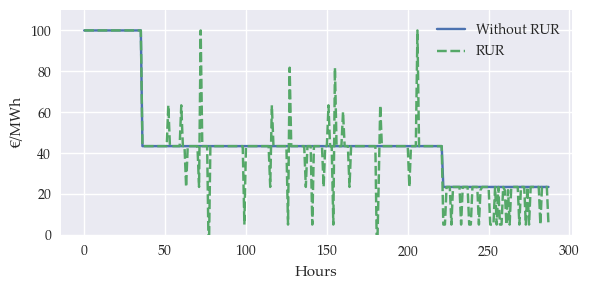

In [31]:
fig, ax = plt.subplots(1,1,figsize = (6,3));
seaborn.lineplot(data = pricesCompare, ax = ax);
ax.set_ylabel('€/MWh');
ax.set_xlabel('Hours');
ax.set_ylim([0, 110]);
fig.tight_layout();

Without the RUR constraints, the "logic of the model" was as followed:
* If demand can be satisfied with the cheapest plant $C$, then this is optimal. 
* Otherwise plant $A$ is active. 
* If plant $A$ and $C$ combined cannot satisfy demand $\rightarrow$ use plant $B$.
* If the three combined cannot satisfy demand $\rightarrow$ a part of the demand is not satisfied, i.e. we have load shedding and the price peaks at 100€/MWh.

With RUR constraints, prices can now at times be higher, because there are hours where plant $A$ and/or $B$ are no longer flexible enough to cover demand (because it is optimal for them to be inactive in the previous hour). Prices can also be lower, however. This is essentially because plants may increase supply in hour $h$ only to satisfy demand in hour $h+1$: This is why the price occasionally drop to zero; plants are willing to produce at a price of zero in hour $h$, because it makes them able to produce more in hour $h+1$ where the price is much higher.

#### Q.2.5.3 Marginal economic value

*Derive the marginal economic value in this extended model (recall that we define this as $\partial \mathcal{L}/\partial q_i$) and comment briefly.*

**Solution:**

Starting from the Lagrangian in **Q2.4** we have

$$\begin{align}
    \dfrac{\partial \mathcal{L}}{\partial q_i} = \sum_h\left(\overline{\theta}_{i,h}^E\cdot\gamma_{i,h}+\lambda_{i,h}^{RUR}\cdot \text{RUR}_i\right)-\text{FOM}_i
\end{align}$$


* Recall that $\overline{\theta}_{i,h}^E$ measures the change in $W$ from allowing $E_{i,h}$ to increase marginally; in hours where the plant $i$ is used to full capacity (i.e. where $E_{i,h} = q_{i,h}$), this will lower the system costs and thus $\overline{\theta}_{i,h}^E>0$. In hours where $E_{i,h}<q_{i,h}$, allowing the plant $i$ to produce more have no effect $\overline{\theta}_{i,h}^E= 0$.
* $\gamma_{i,h}$ measures the exogenous variation in generating capacity. If $\gamma_{i,h}$ is large when $\overline{\theta}_{i,h}^E$ is large, it means that the plant can produce a lot when the prices are high.
* $\lambda_{i,h}^{RUR}\cdot \text{RUR}_i$ measures the marginal effect on $W$ from allowing plant $i$ to operate more flexibly in hour $h$. This will generally be large, if price fluctuations are large and the plant is not flexible.
* $\text{FOM}_i$ is our direct measure of the costs of increasing $q_i$ marginally.

#### Q.2.5.4 Compute Marginal Economic Value and Compare

*Compute marginal economic value and compare to before. Why does the marginal economic value of the wind generator drop, while the value of the natural gas generator $i=B$ increase?*

**Solution:**

In **Q2.2** we defined the marginal economic value *without* the RUR constraint. Here, exploit this and just add the RUR part:

In [32]:
def marginalEconomicValue_RUR(model):
    return marginalEconomicValue(model)-pyDbs.pdSum(model.db['λ_rampUpRate'].droplevel('_type').rename_axis(index=['h','id']) * model.db['RUR'], 'h')
mev_RUR = marginalEconomicValue_RUR(m)

Plot:

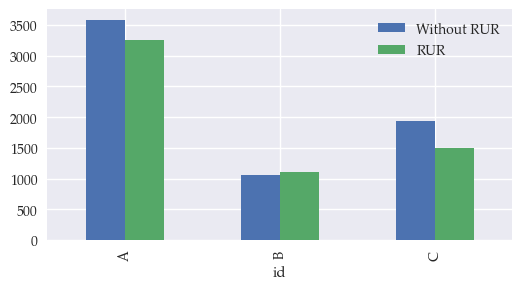

In [33]:
pd.DataFrame({'Without RUR': mev, 'RUR': mev_RUR}).plot.bar(figsize=(6,3));

* The value of the natural gas plant, $B$, increases because (1) it is more flexible than $A$ (higher RUR), and (2) the plant is normally only active during peak hours. This means that there will be hours where $A$ is not flexible enough and $B$ can increase its production.
* The value of the wind generator, $C$, decreases, because plants $A$ and $B$ generally have incentives to increase their supply at lower prices in a lot of hours, because they anticipate higher prices in the future. This drives down prices in hours where $C$ produces a lot.